# Preparação do ambiente

## Montando o drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importando as libs

In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 5.9MB/s 
     |████████████████████████████████| 6.5MB 28.9MB/s 
     |████████████████████████████████| 14.8MB 241kB/s 


In [ ]:
import pandas as pd
import plotly.offline as py
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import geopandas

from scipy import stats
from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

## Leitura do Dataset - Rose

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Datasets/caso_full.csv')
df.info()

FileNotFoundError: ignored

**Metadados:**

* city: nome do município.
* city_ibge_code: código IBGE do local.
* date: data de coleta dos dados no formato YYYY-MM-DD.
* epidemiological_week: número da semana epidemiológica.
* estimated_population: população estimada para esse município/estado em 2020, segundo o IBGE.
* estimated_population_2019: população estimada para esse município/estado em 2019, segundo o IBGE.
* is_last: campo pré-computado que diz se esse registro é o mais novo para esse local, pode ser True ou False.
* is_repeated: campo pré-computado que diz se as informações nesse registro foram publicadas pela Secretaria Estadual de Saúde no dia date ou se o dado é repetido do último dia em que o dado está disponível (igual ou anterior a date). Isso ocorre pois nem todas as secretarias publicam boletins todos os dias. Veja também o campo last_available_date.
* last_available_confirmed: número de casos confirmados do último dia disponível igual ou anterior à data date.
* last_available_confirmed_per_100k_inhabitants: número de casos confirmados por 100.000 habitantes do último dia disponível igual ou anterior à data date.
* last_available_date: data da qual o dado se refere.
last_available_death_rate: taxa de mortalidade (mortes / confirmados) do último dia disponível igual ou anterior à data date.
* last_available_deaths: número de mortes do último dia disponível igual ou anterior à data date.
* order_for_place: número que identifica a ordem do registro para este local. O registro referente ao primeiro boletim em que esse local aparecer será contabilizado como 1 e os demais boletins incrementarão esse valor.
* place_type: tipo de local que esse registro descreve, pode ser city ou state.
* state: sigla da unidade federativa, exemplo: SP.
* new_confirmed: número de novos casos confirmados desde o último dia (note que caso is_repeated seja True, esse valor sempre será 0 e que esse valor pode ser negativo caso a SES remaneje os casos desse município para outro).
* new_deaths: número de novos óbitos desde o último dia (note que caso is_repeated seja True, esse valor sempre será 0 e que esse valor pode ser negativo caso a SES remaneje os casos desse município para outro)d



### Análise exploratória

Amostra do dataset

In [ ]:
df.head(100)

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,São Paulo,3550308.0,2020-02-25,9,12325232.0,12252023.0,False,False,1,0.00811,2020-02-25,0.0,0,1,city,SP,1,0
1,NaN,35.0,2020-02-25,9,46289333.0,45919049.0,False,False,1,0.00216,2020-02-25,0.0,0,1,state,SP,1,0
2,São Paulo,3550308.0,2020-02-26,9,12325232.0,12252023.0,False,False,1,0.00811,2020-02-26,0.0,0,2,city,SP,0,0
3,NaN,35.0,2020-02-26,9,46289333.0,45919049.0,False,False,1,0.00216,2020-02-26,0.0,0,2,state,SP,0,0
4,São Paulo,3550308.0,2020-02-27,9,12325232.0,12252023.0,False,False,1,0.00811,2020-02-27,0.0,0,3,city,SP,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Campo Bom,4303905.0,2020-03-11,11,69458.0,66712.0,False,False,1,1.43972,2020-03-11,0.0,0,2,city,RS,0,0
96,Porto Alegre,4314902.0,2020-03-11,11,1488252.0,1483771.0,False,False,1,0.06719,2020-03-11,0.0,0,1,city,RS,1,0
97,Santana de Parnaíba,3547304.0,2020-03-11,11,142301.0,139447.0,False,False,1,0.70274,2020-03-11,0.0,0,5,city,SP,0,0
98,São Paulo,3550308.0,2020-03-11,11,12325232.0,12252023.0,False,False,29,0.23529,2020-03-11,0.0,0,16,city,SP,11,0


Análise descritiva do dataset

In [ ]:
# Identificando algumas questões importantes a partir do describe do dataset
# - que o contagio do virus começou por volta da semana 9 do ano ( final de fevereiro);
# - valores negativos nos atributos 'new_confirmed' e 'new_deaths' indicam que alguns casos foram remanejados para outros municipios
# - a média dos casos confirmados é menor que a média dos casos de morte.
# - - Ou muitas pessoas que morreram de covid nao fizeram o teste antes
# - - Ou é uma inflação dos números de mortes por covid
# - existem cidades com menos de 1 mil habitantes - Serra da Saudade / MG
# - cidade mais populosa com mais de 40 milhoes de habitantes - ###### / SP
# - a maior taxa de mortos/confirmados aculados foi 1, 
# - - indicando que existiu um momento em que o numero total de mortos foi igual ao numero total de confirmados
# - maior numero de mortes em um unico dia (455 mortes) - ###### / SP
# - maior numero de confirmados em um unico dia (30913) - ###### / SC
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
city_ibge_code,1192447.0,3.207092e+06,1.012613e+06,11.00000,2.505709e+06,3.141900e+06,4.114401e+06,5.300108e+06
epidemiological_week,1197106.0,3.454301e+01,9.280022e+00,9.00000,2.700000e+01,3.500000e+01,4.200000e+01,5.000000e+01
estimated_population,1192447.0,9.338124e+04,9.937708e+05,776.00000,5.981000e+03,1.310400e+04,2.912700e+04,4.628933e+07
estimated_population_2019,1192447.0,9.266501e+04,9.865870e+05,781.00000,5.971000e+03,1.308100e+04,2.893500e+04,4.591905e+07
last_available_confirmed,1197106.0,1.219864e+03,1.499225e+04,0.00000,1.600000e+01,7.900000e+01,3.170000e+02,1.306585e+06
last_available_confirmed_per_100k_inhabitants,1177091.0,1.270545e+03,1.529872e+03,0.00216,1.856853e+02,7.797271e+02,1.808013e+03,2.527765e+04
last_available_death_rate,1197106.0,3.357678e-02,8.483316e-02,0.00000,0.000000e+00,1.600000e-02,3.410000e-02,1.000000e+00
last_available_deaths,1197106.0,3.830974e+01,5.470176e+02,0.00000,0.000000e+00,2.000000e+00,7.000000e+00,4.346100e+04
order_for_place,1197106.0,1.092073e+02,6.491211e+01,1.00000,5.400000e+01,1.070000e+02,1.610000e+02,2.890000e+02
new_confirmed,1197106.0,1.121435e+01,1.471798e+02,-6791.00000,0.000000e+00,0.000000e+00,2.000000e+00,3.091300e+04


In [ ]:
# menor população
print((df[df.estimated_population == df.estimated_population.min()]).drop_duplicates(subset='city'))
print('\n')

# maior população
print((df[df.estimated_population == df.estimated_population.max()]).drop_duplicates(subset='city'))
print('\n')

# maior numero de confirmador por covid
print((df[df.new_confirmed == df.new_confirmed.max()]).drop_duplicates(subset='city'))
print('\n')

# maior numero de mortes por covid
print((df[df.new_deaths == df.new_deaths.max()]).drop_duplicates(subset='city'))
print('\n')

print((df[df.last_available_death_rate == df.last_available_death_rate.max()]).drop_duplicates(subset='city'))

                    city  city_ibge_code  ... new_confirmed  new_deaths
272166  Serra da Saudade       3166600.0  ...             0           0

[1 rows x 18 columns]


  city  city_ibge_code        date  ...  state  new_confirmed  new_deaths
1  NaN            35.0  2020-02-25  ...     SP              1           0

[1 rows x 18 columns]


       city  city_ibge_code        date  ...  state  new_confirmed  new_deaths
635773  NaN            42.0  2020-08-31  ...     SC          30913          25

[1 rows x 18 columns]


       city  city_ibge_code        date  ...  state  new_confirmed  new_deaths
534992  NaN            35.0  2020-08-13  ...     SP          19274         455

[1 rows x 18 columns]


                          city  city_ibge_code  ... new_confirmed  new_deaths
553             Miguel Pereira       3302908.0  ...             1           1
1773           Taboão da Serra       3552809.0  ...             1           1
1856                  Luziânia       5212501.0  ...       

### Valores Faltantes

In [ ]:
# Explicações para os dados faltantes:
# - ciy: alguns registros fazem referência ao estado e por isso o campo 'city' nao tem valor;
# - - Ou seja, neste caso o atributo é do tipo faltando aleatorio - MAR
# - city_ibge_code: o mesmo do atributo anterior;
# - estimated_population: alguns registros não foram computados devido ao dados desatualizados do ibge;
# - estimated_poplation_2019: o mesmo do atributo anterior;
# - last_availble_confirmed_per_100k_inhabitants: dados computados referents à 'estimated_population', que possuem registros faltantes também.
# - - formula para calcular o valor do atributo: (numero de casos confirmados * 100000) / numero estimado da população
# Tratando valores ausentes
# - como nao existe como saber de qual cidade pertence tal registro, o mesmo sera retirado
df.isnull().sum()

city                                              7348
city_ibge_code                                    4659
date                                                 0
epidemiological_week                                 0
estimated_population                              4659
estimated_population_2019                         4659
is_last                                              0
is_repeated                                          0
last_available_confirmed                             0
last_available_confirmed_per_100k_inhabitants    20015
last_available_date                                  0
last_available_death_rate                            0
last_available_deaths                                0
order_for_place                                      0
place_type                                           0
state                                                0
new_confirmed                                        0
new_deaths                                           0
dtype: int

Tratando os valores faltantes

In [ ]:
# atributo 'last_available_confirmed_per_100k_inhabitants'
# recalculando os valores do atributo para preencher a partir do atributo 'last_available_confirmed'
# MCAR - completamente aleatório

df['last_available_confirmed_per_100k_inhabitants'].fillna((df.last_available_confirmed * 100000) / df.estimated_population, inplace=True)

In [ ]:
# atributo 'city'
# retirar todos os registro que possuem o valor 'Importados/Indefinidos' ou valor nulo do atributo 'city',
#   pois é um registro que faz referencia ao estado como um todo e nao apenas a uma cidade específica
# MAR - aleatório
df = df[(df.city.isnull() == False) & (df.city != 'Importados/Indefinidos')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1185099 entries, 0 to 1197078
Data columns (total 18 columns):
 #   Column                                         Non-Null Count    Dtype  
---  ------                                         --------------    -----  
 0   city                                           1185099 non-null  object 
 1   city_ibge_code                                 1185099 non-null  float64
 2   date                                           1185099 non-null  object 
 3   epidemiological_week                           1185099 non-null  int64  
 4   estimated_population                           1185099 non-null  float64
 5   estimated_population_2019                      1185099 non-null  float64
 6   is_last                                        1185099 non-null  bool   
 7   is_repeated                                    1185099 non-null  bool   
 8   last_available_confirmed                       1185099 non-null  int64  
 9   last_available_confirmed

### Análise descritiva - dados não-nulos

In [ ]:
# Identificando algumas questões importantes a partir do describe do dataset sem valores nulos
# - existem cidades com menos de 1 mil habitantes - Serra da Saudade / MG
# - cidade mais populosa com mais de 12 milhoes de habitantes - Sao Paulo / SP
# - maior numero de mortes em um unico dia (438 mortes) - Cuiaba / SC
# - maior numero de confirmados em um unico dia (19345) - Cuiaba / SC
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
city_ibge_code,1185099.0,3.226976e+06,983653.778548,1100015.0,2.508208e+06,3.143450e+06,4.115200e+06,5.300108e+06
epidemiological_week,1185099.0,3.457646e+01,9.254734,9.0,2.700000e+01,3.500000e+01,4.200000e+01,5.000000e+01
estimated_population,1185099.0,4.445060e+04,255915.769243,776.0,5.946000e+03,1.301400e+04,2.870400e+04,1.232523e+07
estimated_population_2019,1185099.0,4.410541e+04,254277.955496,781.0,5.949000e+03,1.295700e+04,2.851600e+04,1.225202e+07
last_available_confirmed,1185099.0,6.079910e+02,4599.402958,0.0,1.600000e+01,7.800000e+01,3.080000e+02,3.634950e+05
last_available_confirmed_per_100k_inhabitants,1185099.0,1.251243e+03,1524.403925,0.0,1.704546e+02,7.582833e+02,1.782747e+03,2.527765e+04
last_available_death_rate,1185099.0,3.354734e-02,0.084749,0.0,0.000000e+00,1.590000e-02,3.410000e-02,1.000000e+00
last_available_deaths,1185099.0,1.922976e+01,217.097694,0.0,0.000000e+00,2.000000e+00,7.000000e+00,1.476100e+04
order_for_place,1185099.0,1.089732e+02,64.734998,1.0,5.400000e+01,1.070000e+02,1.610000e+02,2.890000e+02
new_confirmed,1185099.0,5.595520e+00,48.982970,-906.0,0.000000e+00,0.000000e+00,2.000000e+00,1.934500e+04


In [ ]:
print((df[df.estimated_population == df.estimated_population.min()]).drop_duplicates(subset='city'))
print('\n')
print((df[df.estimated_population == df.estimated_population.max()]).drop_duplicates(subset='city'))
print('\n')
print((df[df.new_confirmed == df.new_confirmed.max()]).drop_duplicates(subset='city'))
print('\n')
print((df[df.new_deaths == df.new_deaths.max()]).drop_duplicates(subset='city'))

                    city  city_ibge_code  ... new_confirmed  new_deaths
272166  Serra da Saudade       3166600.0  ...             0           0

[1 rows x 18 columns]


        city  city_ibge_code        date  ...  state  new_confirmed  new_deaths
0  São Paulo       3550308.0  2020-02-25  ...     SP              1           0

[1 rows x 18 columns]


           city  city_ibge_code        date  ...  state  new_confirmed  new_deaths
1087124  Cuiabá       5103403.0  2020-11-20  ...     MT          19345         438

[1 rows x 18 columns]


           city  city_ibge_code        date  ...  state  new_confirmed  new_deaths
1087124  Cuiabá       5103403.0  2020-11-20  ...     MT          19345         438

[1 rows x 18 columns]


Analise da correlação dos atributos nominais

In [ ]:
# Os atributos 'city' e 'city_ibge_code' estão ALTAMENTE relacionados com o atributos 'state'
#   portanto, esses atributos são redundantes para nossa análise
# - teste chi quadrado, p < 0,05

df_cross_city_state=pd.crosstab(df.city, df.state)
df_cross_ibge_state=pd.crosstab(df.city_ibge_code, df.city)
print(f'Correlação entre os atributos \'city\' e \'state\': {stats.chi2_contingency(df_cross_city_state)[1]}')
print(f'Correlação entre os atributos \'city_ibge_code \' e \'city\': {stats.chi2_contingency(df_cross_ibge_state)[1]}')

Correlação entre os atributos 'city' e 'state': 0.0
Correlação entre os atributos 'city_ibge_code ' e 'city': 0.0


Análise da correlação dos atributos numericos

In [ ]:
# last_available_confirmed X new_confirmed
#   estão correlacionados positivamente
# - função de correlação pelo método de pearson

df_01 = df[['new_confirmed', 'last_available_confirmed']]
print(df_01.corr(method='pearson'))
print('\n')

trace_01 = go.Scatter(x=df['new_confirmed'][:10000], y=df['last_available_confirmed'][:10000], mode='markers')
py.iplot([trace_01])


                          new_confirmed  last_available_confirmed
new_confirmed                   1.00000                   0.53202
last_available_confirmed        0.53202                   1.00000




In [ ]:

# last_available_confirmed_per_100k_inhabitants last_available_confirmed
#   não estão correlacionados
df_02 = df[['last_available_confirmed_per_100k_inhabitants', 'last_available_confirmed']]
print(df_02.corr(method='pearson'))
print('\n')

# last_available_deaths last_available_confirmed
#   estão correlacionado positivamente
df_03 = df[['last_available_deaths', 'last_available_confirmed']]
print(df_03.corr(method='pearson'))
print('\n')


# new_deaths new_confirmed
#   estão correlacionado positivamente
df_04 = df[['new_deaths', 'new_confirmed']]
print(df_04.corr(method='pearson'))

                                               last_available_confirmed_per_100k_inhabitants  last_available_confirmed
last_available_confirmed_per_100k_inhabitants                                        1.00000                   0.15009
last_available_confirmed                                                             0.15009                   1.00000


                          last_available_deaths  last_available_confirmed
last_available_deaths                  1.000000                  0.882276
last_available_confirmed               0.882276                  1.000000


               new_deaths  new_confirmed
new_deaths       1.000000       0.678077
new_confirmed    0.678077       1.000000


Retirada de atributos que não serão necessários para nossa análise

In [ ]:
# Atributos reduntantes ou que fazem referência a índices
df.drop(['city_ibge_code', 'order_for_place', 'place_type'], inplace=True, axis=1)

### Importancia das Features - Cinthia

In [ ]:
#Função para importance features 
df_features = df[['epidemiological_week',	'estimated_population',	'estimated_population_2019', 'last_available_confirmed',	'last_available_confirmed_per_100k_inhabitants', 'last_available_death_rate',	'last_available_deaths',	'new_confirmed',	'new_deaths']][:1000]

#Função para importance features 
def importance_features_tree(name, model, X, Y):
  model.fit(X,Y)
  
  print(f'# {name}')
  print('Features sorted by their score:')  
  print(sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), df_features.columns), reverse=True))

  # Plot feature importance
  feature_importance = model.feature_importances_
  # Make importances relative to max importance
  feature_importance = 100.0  * (feature_importance / feature_importance.max())
  sorted_idx = np.argsort(feature_importance)
  pos = np.arange(sorted_idx.shape[0]) + .5
  plt.subplot(1,2,2)
  plt.barh(pos,feature_importance[sorted_idx], align='center')

  m_name = np.array(df_features.columns)
  plt.yticks(pos, m_name[sorted_idx])
  plt.xlabel('Importancia Relativa')
  plt.show()


def importance_feature_filter(name,func, X, Y, n):
  test = SelectKBest(score_func=func, k=n)
  fit = test.fit(X, Y)

  # Sumarize scores
  np.set_printoptions(precision=3)
  # print(fit.scores_)

  features = fit.transform(X)
  # Sumarize selected features
  # print(f'\nfeatures {feature[0:5,:]}')

  print(f'# {name}')
  print('\nFeatures sorted by their score:')
  print(sorted(zip(map(lambda x: round(x, 4), fit.scores_), df_features.columns), reverse=True))


  # Plot feature importance
  feature_importance = fit.scores_
  # Make importances relative to max importance
  feature_importance = 100.0  * (feature_importance / feature_importance.max())
  sorted_idx = np.argsort(feature_importance)
  pos = np.arange(sorted_idx.shape[0]) + .5
  plt.subplot(1,2,2)
  plt.barh(pos,feature_importance[sorted_idx], align='center')

  m_name = np.array(df_features.columns)
  plt.yticks(pos, m_name[sorted_idx])
  plt.xlabel('Importancia Relativa')
  plt.show()

def importance_feature_wrapper(name, model, X, Y, n, columns):
  rfe = RFE(model, n)
  fit = rfe.fit(X, Y)

  print(f'# {name}')
  print(f'Num features: {fit.n_features_}')
  print(f'Features ranking labels: {[columns[i] for i in np.where(fit.ranking_ == 1)[0]]}')

def importance_feature_wrapper(name, model, X, Y, n, columns):
  rfe = RFE(model, n)
  fit = rfe.fit(X, Y)

  print(f'# {name}')
  print(f'Num features: {fit.n_features_}')
  print(f'Features ranking labels: {[columns[i] for i in np.where(fit.ranking_ == 1)[0]]}')

def class_(value, Q1, Q2, Q3):
  if value < Q1:
    return 1
  elif Q1 <= value < Q2:
    return 2
  elif Q2 <= value < Q3:
    return 3
  else:
    return 4

NameError: ignored

Atributos sem normalização - 10k de dados

Usando Árvores
# RandomForest
Features sorted by their score:
[(0.4361, 'new_confirmed'), (0.2677, 'last_available_confirmed'), (0.1311, 'last_available_death_rate'), (0.0947, 'last_available_deaths'), (0.0399, 'last_available_confirmed_per_100k_inhabitants'), (0.0165, 'epidemiological_week'), (0.0075, 'estimated_population_2019'), (0.0065, 'estimated_population')]


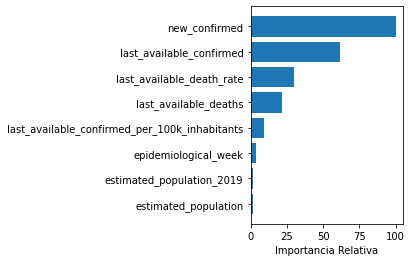

# Gradiente Boosting
Features sorted by their score:
[(0.4352, 'new_confirmed'), (0.4068, 'last_available_confirmed'), (0.065, 'last_available_death_rate'), (0.0489, 'last_available_deaths'), (0.0281, 'last_available_confirmed_per_100k_inhabitants'), (0.0114, 'epidemiological_week'), (0.003, 'estimated_population_2019'), (0.0017, 'estimated_population')]


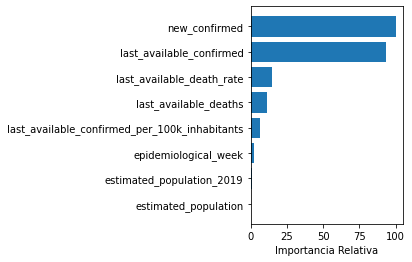


Usando Método de Filtragem
# f Regression

Features sorted by their score:
[(419.5412, 'last_available_deaths'), (381.1267, 'last_available_confirmed'), (218.2174, 'new_confirmed'), (82.4981, 'estimated_population_2019'), (82.4618, 'estimated_population'), (26.2704, 'last_available_death_rate'), (0.0155, 'epidemiological_week'), (0.0014, 'last_available_confirmed_per_100k_inhabitants')]


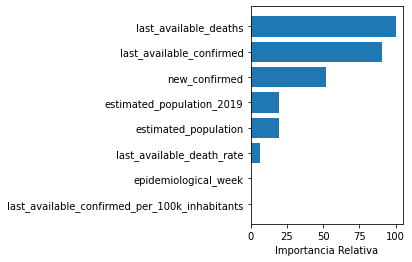

In [ ]:
# Importancia dos atributos
array_n = df_features.values
X = array_n[:,0:8]
Y = array_n[:,8]

# Usando Arvores
# RandomForest
print('Usando Árvores')
importance_features_tree('RandomForest', RandomForestRegressor(), X, Y)

# GradientBoosting
importance_features_tree('Gradiente Boosting', GradientBoostingRegressor(), X, Y)

print('\nUsando Método de Filtragem')
# Usando Método de Filtragem
# Chi2
# Não pode conter valores negativos
# importance_feature_filter('chi2', chi2, X, Y, 4)

# f_regression
importance_feature_filter('f Regression', f_regression, X, Y, 4)

# print('\nUsando Método Wrapper')
# Usando Metodo Wrapper
# importance_feature_wrapper('Regreção Logística', LogisticRegression(), X, Y, 4, df_features.columns[:8])
# importance_feature_wrapper('Árvore: ExtreTreeClassifier', ExtraTreeClassifier(), X, Y, 4, df_features.columns[:8])

Atributos com normalização - 10k de dados

In [ ]:
df_features['epidemiological_week'] = df_features.epidemiological_week.apply(lambda value: (value - df_features.epidemiological_week.min()) / (df_features.epidemiological_week.max() - df_features.epidemiological_week.min()))
df_features['estimated_population'] = df_features.estimated_population.apply(lambda value: (value - df_features.estimated_population.min()) / (df_features.estimated_population.max() - df_features.estimated_population.min()))
df_features['estimated_population_2019'] = df_features.estimated_population_2019.apply(lambda value: (value - df_features.estimated_population_2019.min()) / (df_features.estimated_population_2019.max() - df_features.estimated_population_2019.min()))
df_features['last_available_confirmed'] = df_features.last_available_confirmed.apply(lambda value: (value - df_features.last_available_confirmed.min()) / (df_features.last_available_confirmed.max() - df_features.last_available_confirmed.min()))
df_features['last_available_confirmed_per_100k_inhabitants'] = df_features.last_available_confirmed_per_100k_inhabitants.apply(lambda value: (value - df_features.last_available_confirmed_per_100k_inhabitants.min()) / (df_features.last_available_confirmed_per_100k_inhabitants.max() - df_features.last_available_confirmed_per_100k_inhabitants.min()))
df_features['last_available_death_rate'] = df_features.last_available_death_rate.apply(lambda value: (value - df_features.last_available_death_rate.min()) / (df_features.last_available_death_rate.max() - df_features.last_available_death_rate.min()))
df_features['last_available_deaths'] = df_features.last_available_deaths.apply(lambda value: (value - df_features.last_available_deaths.min()) / (df_features.last_available_deaths.max() - df_features.last_available_deaths.min()))
df_features['new_confirmed'] = df_features.new_confirmed.apply(lambda value: (value - df_features.new_confirmed.min()) / (df_features.new_confirmed.max() - df_features.new_confirmed.min()))

NameError: ignored

Usando Árvores
# RandomForest
Features sorted by their score:
[(0.4654, 'new_confirmed'), (0.1764, 'last_available_confirmed'), (0.1746, 'last_available_deaths'), (0.1305, 'last_available_death_rate'), (0.0296, 'last_available_confirmed_per_100k_inhabitants'), (0.0128, 'epidemiological_week'), (0.006, 'estimated_population'), (0.0047, 'estimated_population_2019')]


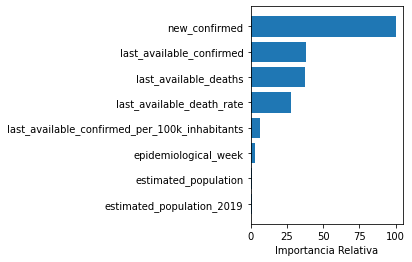

# Gradiente Boosting
Features sorted by their score:
[(0.4251, 'new_confirmed'), (0.415, 'last_available_confirmed'), (0.0598, 'last_available_death_rate'), (0.0413, 'last_available_deaths'), (0.0378, 'last_available_confirmed_per_100k_inhabitants'), (0.0111, 'epidemiological_week'), (0.0067, 'estimated_population'), (0.0032, 'estimated_population_2019')]


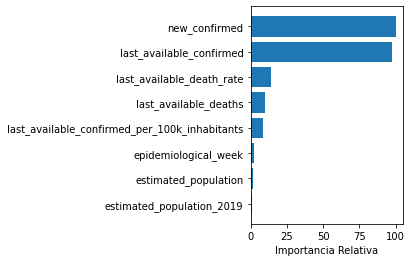


Usando Método de Filtragem
# f Regression

Features sorted by their score:
[(419.5412, 'last_available_deaths'), (381.1267, 'last_available_confirmed'), (218.2174, 'new_confirmed'), (82.4981, 'estimated_population_2019'), (82.4618, 'estimated_population'), (26.2704, 'last_available_death_rate'), (0.0155, 'epidemiological_week'), (0.0014, 'last_available_confirmed_per_100k_inhabitants')]


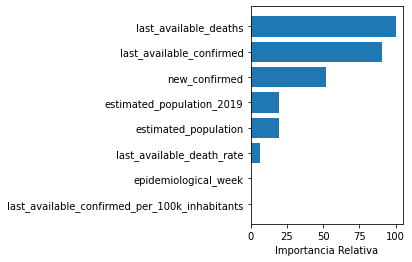

In [ ]:
# Importancia dos atributos
array_n = df_features.values
X = array_n[:,0:8]
Y = array_n[:,8]

# Usando Arvores
# RandomForest
print('Usando Árvores')
importance_features_tree('RandomForest', RandomForestRegressor(), X, Y)

# GradientBoosting
importance_features_tree('Gradiente Boosting', GradientBoostingRegressor(), X, Y)

print('\nUsando Método de Filtragem')
# Usando Método de Filtragem
# Chi2
# Não pode conter valores negativos
# importance_feature_filter('chi2', chi2, X, Y, 4)

# f_regression
importance_feature_filter('f Regression', f_regression, X, Y, 4)

# print('\nUsando Método Wrapper')
# Usando Metodo Wrapper
# importance_feature_wrapper('Regreção Logística', LogisticRegression(), X, Y, 4, df_features.columns[:8])
# importance_feature_wrapper('Árvore: ExtreTreeClassifier', ExtraTreeClassifier(), X, Y, 4, df_features.columns[:8])

Atributos com Discretização nos Quartis - 10k de dados

In [ ]:
df_features['epidemiological_week'] = df_features.epidemiological_week.apply(class_, args=(df_features.epidemiological_week.quantile([.25,.5,.75]).values.tolist()))
df_features['estimated_population'] = df_features.estimated_population.apply(class_, args=(df_features.estimated_population.quantile([.25,.5,.75]).values.tolist()))
df_features['estimated_population_2019'] = df_features.estimated_population_2019.apply(class_, args=(df_features.estimated_population_2019.quantile([.25,.5,.75]).values.tolist()))
df_features['last_available_confirmed'] = df_features.last_available_confirmed.apply(class_, args=(df_features.last_available_confirmed.quantile([.25,.5,.75]).values.tolist()))
df_features['last_available_confirmed_per_100k_inhabitants'] = df_features.last_available_confirmed_per_100k_inhabitants.apply(class_, args=(df_features.last_available_confirmed_per_100k_inhabitants.quantile([.25,.5,.75]).values.tolist()))
df_features['last_available_death_rate'] = df_features.last_available_death_rate.apply(class_, args=(df_features.last_available_death_rate.quantile([.25,.5,.75]).values.tolist()))
df_features['last_available_deaths'] = df_features.last_available_deaths.apply(class_, args=(df_features.last_available_deaths.quantile([.25,.5,.75]).values.tolist()))
df_features['new_confirmed'] = df_features.new_confirmed.apply(class_, args=(df_features.new_confirmed.quantile([.25,.5,.75]).values.tolist()))

Usando Árvores
# RandomForest
Features sorted by their score:
[(0.437, 'new_confirmed'), (0.2071, 'last_available_confirmed'), (0.1664, 'last_available_deaths'), (0.1213, 'last_available_death_rate'), (0.0387, 'last_available_confirmed_per_100k_inhabitants'), (0.0175, 'epidemiological_week'), (0.0063, 'estimated_population'), (0.0056, 'estimated_population_2019')]


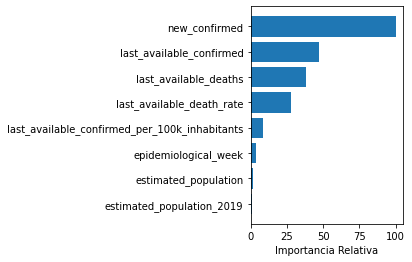

# Gradiente Boosting
Features sorted by their score:
[(0.4247, 'new_confirmed'), (0.4202, 'last_available_confirmed'), (0.0675, 'last_available_deaths'), (0.0546, 'last_available_death_rate'), (0.0118, 'last_available_confirmed_per_100k_inhabitants'), (0.0113, 'epidemiological_week'), (0.005, 'estimated_population'), (0.0048, 'estimated_population_2019')]


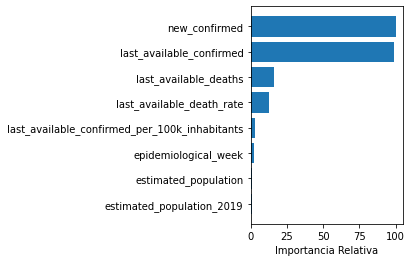


Usando Método de Filtragem
# f Regression

Features sorted by their score:
[(419.5412, 'last_available_deaths'), (381.1267, 'last_available_confirmed'), (218.2174, 'new_confirmed'), (82.4981, 'estimated_population_2019'), (82.4618, 'estimated_population'), (26.2704, 'last_available_death_rate'), (0.0155, 'epidemiological_week'), (0.0014, 'last_available_confirmed_per_100k_inhabitants')]


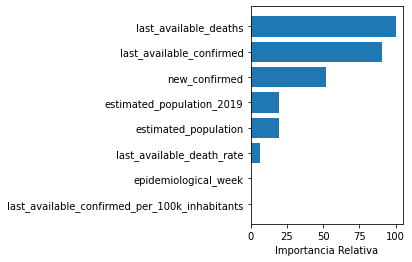


Usando Método Wrapper


In [ ]:
# Importancia dos atributos
array_n = df_features.values
X = array_n[:,0:8]
Y = array_n[:,8]

# Usando Arvores
# RandomForest
print('Usando Árvores')
importance_features_tree('RandomForest', RandomForestRegressor(), X, Y)

# GradientBoosting
importance_features_tree('Gradiente Boosting', GradientBoostingRegressor(), X, Y)

print('\nUsando Método de Filtragem')
# Usando Método de Filtragem
# Chi2
# Não pode conter valores negativos
# importance_feature_filter('chi2', chi2, X, Y, 4)

# f_regression
importance_feature_filter('f Regression', f_regression, X, Y, 4)

print('\nUsando Método Wrapper')
# Usando Metodo Wrapper
# importance_feature_wrapper('Regreção Logística', LogisticRegression(), X, Y, 4, df_features.columns[:8])
# importance_feature_wrapper('Árvore: ExtreTreeClassifier', ExtraTreeClassifier(), X, Y, 4, df_features.columns[:8])

### Análise Gráfica

Quantidade de mortos por estado - proporcionalmente

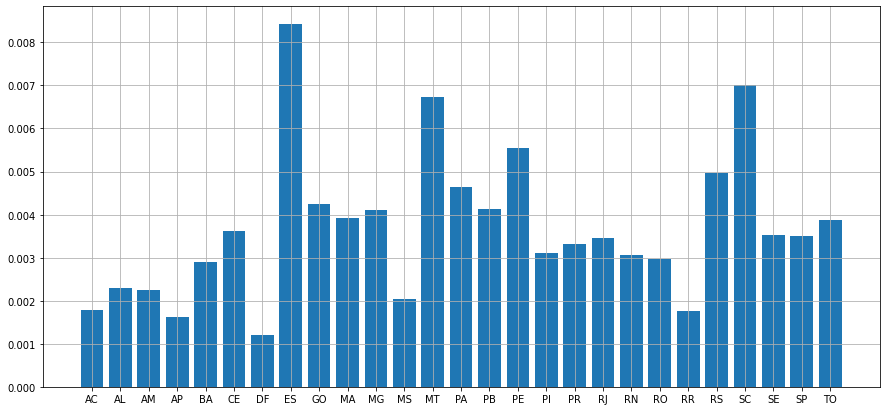

In [ ]:
df_group01 = df[['new_deaths']].groupby(df['state'])

fig, ax = plt.subplots(figsize=(15,7))
x = df_group01.sum().index.values
y = [value / df[df.state == stt]['estimated_population'].max() for value, stt in zip(df_group01.sum().values.reshape(-1), df_group01.sum().index.values)]
ax.bar(x,y)
plt.grid()
plt.show()

Quantidade de casos por estado - proporcionalmente

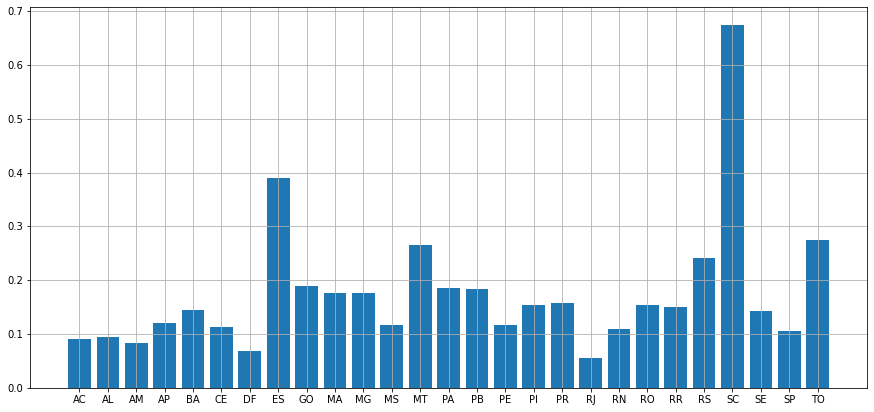

In [ ]:
df_group02 = df[['new_confirmed']].groupby(df['state'])

fig, ax = plt.subplots(figsize=(15,7))
x = df_group02.sum().index.values
y = [value / df[df.state == stt]['estimated_population'].max() for value, stt in zip(df_group02.sum().values.reshape(-1), df_group02.sum().index.values)]
ax.bar(x,y)
plt.grid()
plt.show()

Quantidade de mortes ao longos das semanas

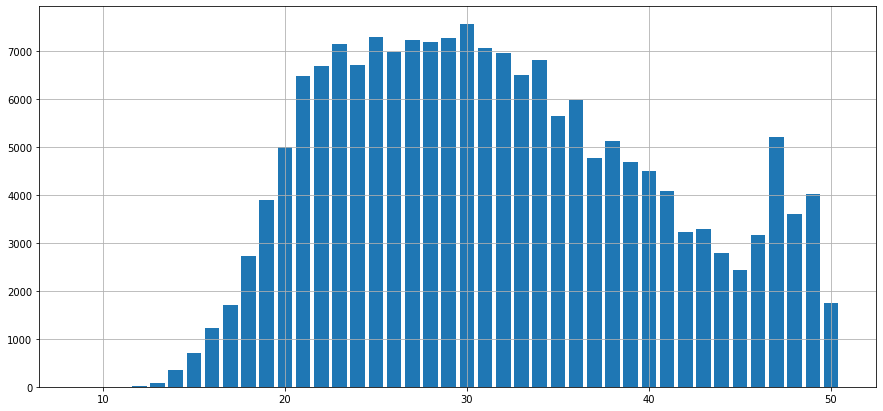

In [ ]:
df_group03 = df[['new_deaths']].groupby(df['epidemiological_week'])

fig, ax = plt.subplots(figsize=(15,7))
x = df_group03.sum().index.values
y = df_group03.sum().values.reshape(-1)
ax.bar(x, y)
plt.grid()
plt.show()

Distribuição de infectados aos longo das semanas

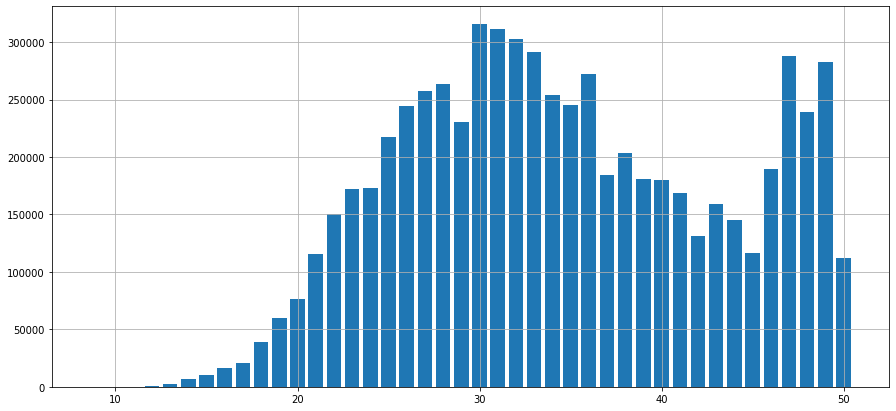

In [ ]:
df_group03 = df[['new_confirmed']].groupby(df['epidemiological_week'])

fig, ax = plt.subplots(figsize=(15,7))
x = df_group03.sum().index.values
y = df_group03.sum().values.reshape(-1)
ax.bar(x, y)
plt.grid()
plt.show()


Distribuição de mortes por covid

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



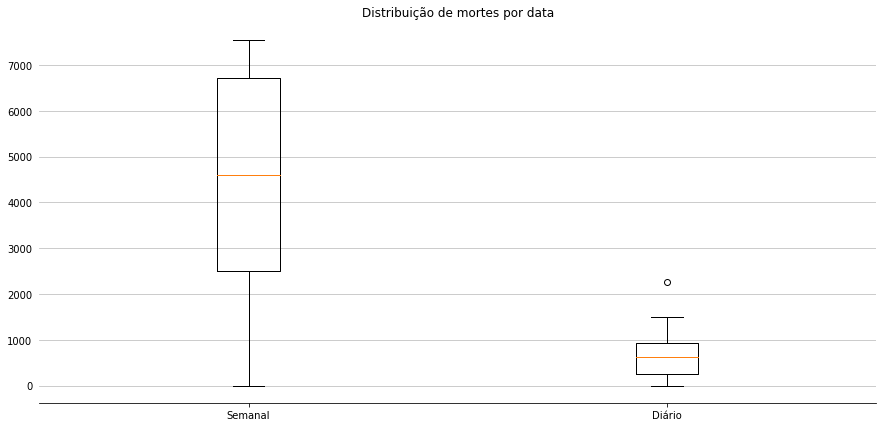

In [ ]:
df_group04 = df[['new_deaths']].groupby(df['epidemiological_week'])
df_group05 = df[['new_deaths']].groupby(df['date'])
data1 = df_group04.sum().values.reshape(-1)
data2 = df_group05.sum().values.reshape(-1)
data = [data1, data2]

fig, ax = plt.subplots(figsize=(15,7))

# Remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# Remove y-axis tick marks
ax.yaxis.set_ticks_position('none')
# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', alpha=0.5)
# Set plot title
ax.set_title('Distribuição de mortes por data')
# Set names as labels for the boxplot
labels = ['Semanal', 'Diário']
plt.boxplot(data, labels=labels)
plt.show()

Distrobuição de infectados por covid

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



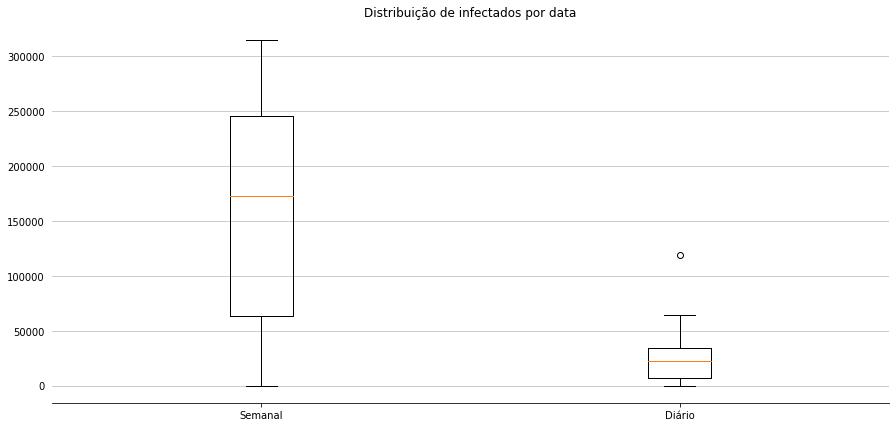

In [ ]:
df_group06 = df[['new_confirmed']].groupby(df['epidemiological_week'])
df_group07 = df[['new_confirmed']].groupby(df['date'])
data1 = df_group06.sum().values.reshape(-1)
data2 = df_group07.sum().values.reshape(-1)
data = [data1, data2]

fig, ax = plt.subplots(figsize=(15,7))

# Remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# Remove y-axis tick marks
ax.yaxis.set_ticks_position('none')
# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', alpha=0.5)
# Set plot title
ax.set_title('Distribuição de infectados por data')
# Set names as labels for the boxplot
labels = ['Semanal', 'Diário']
plt.boxplot(data, labels=labels)
plt.show()

 A partir daqui esquece

Distribuição Geográfica

In [ ]:
data = {
    'AC': [ -8.77, -70.55]
  , 'AL': [ -9.71, -35.73]
  , 'AM': [ -3.07, -61.66]
  , 'AP': [  1.41, -51.77]
  , 'BA': [-12.96, -38.51]
  , 'CE': [ -3.71, -38.54]
  , 'DF': [-15.83, -47.86]
  , 'ES': [-19.19, -40.34]
  , 'GO': [-16.64, -49.31]
  , 'MA': [ -2.55, -44.30]
  , 'MT': [-12.64, -55.42]
  , 'MS': [-20.51, -54.54]
  , 'MG': [-18.10, -44.38]
  , 'PA': [ -5.53, -52.29]
  , 'PB': [ -7.06, -35.55]
  , 'PR': [-24.89, -51.55]
  , 'PE': [ -8.28, -35.07]
  , 'PI': [ -8.28, -43.68]
  , 'RJ': [-22.84, -43.15]
  , 'RN': [ -5.22, -36.52]
  , 'RO': [-11.22, -62.80]
  , 'RS': [-30.01, -51.22]
  , 'RR': [  1.89, -61.22]
  , 'SC': [-27.33, -49.44]
  , 'SE': [-10.90, -37.07]
  , 'SP': [-23.55, -46.64]
  , 'TO': [-10.25, -48.25]
}
city = list(data.keys())
longitude = [value[0] for value in data.values()]
latitude = [value[1] for value in data.values()]

df_states = pd.DataFrame({'state':city, 'latitude':latitude, 'longitude':longitude})
df = df.merge(df_states, on='state', how='left')

In [ ]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.latitude, df.longitude))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.name == 'Brazil'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

In [ ]:
#g = geopandas.GeoDataFrame(
 #   df[:100], geometry=geopandas.points_from_xy(df[:100].latitude, df[:100].longitude))

world = geopandas.read_file('/content/drive/My Drive/Datasets/bcim_2016_21_11_2018.gpkg', layer='lim_unidade_federacao_a')

#agg = df[:100].groupby(df.state).count()[['new_deaths']].reset_index()
#agg['sigla'] = agg['state']

#world = world.merge(agg, on='sigla', how='left')


In [ ]:
df.groupby(df.state).count()[['new_deaths']]